**Installing latest pickle to unserialize our data from database**

In [1]:
!pip install pickle5


     |████████████████████████████████| 133kB 18.6MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp36-cp36m-linux_x86_64.whl size=218621 sha256=c765e1c1ec2f8c3e2acd4e87a1c2e6ca3dbb3858783f4aea65c2719699f4b051
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


**Adding needed imports**

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
import  pickle5 as pickle
from HandReading import HandReading
from Imu import Imu
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, LSTM, GRU
from sklearn.metrics import accuracy_score as acc
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping

Mounted at /content/drive


**Creating dictionary mappers**


In [4]:
dict_word_id = {}
dict_id_word = {}

database_baseurl = '/content/drive/MyDrive/database'
list_word = os.listdir(database_baseurl) 
for j in range(len(list_word)) : 
  dict_word_id[list_word[j]] = j
  dict_id_word[j] = list_word[j]
print(dict_word_id)
print(dict_id_word)

{'oi': 0, 'tchau': 1, 'abdullah': 2, 'prazer-em-te-conhecer': 3, 'silencio': 4, 'lucas': 5, '23': 6, 'qual-seu-nome': 7, 'qual-a-sua-idade': 8, 'meu-nome-e': 9, 'tudo-bem': 10}
{0: 'oi', 1: 'tchau', 2: 'abdullah', 3: 'prazer-em-te-conhecer', 4: 'silencio', 5: 'lucas', 6: '23', 7: 'qual-seu-nome', 8: 'qual-a-sua-idade', 9: 'meu-nome-e', 10: 'tudo-bem'}


**Preparing input and labels data**

In [5]:
input_data, output = [], []
list_word = os.listdir(database_baseurl) 

for word in list_word:
  list_pickle_file = os.listdir(f'{database_baseurl}/{word}')
  k = 0 
  for pickle_file in list_pickle_file:
    k+=1
    with open(f'{database_baseurl}/{word}/{pickle_file}', 'rb') as input:
      readings = pickle.load(input)
      for reading in readings:
        finger = []
        for i in range(5):
          finger.append(np.float16(reading.imus[i].accel[0]/255.0))
          finger.append(np.float16(reading.imus[i].accel[1]/255.0))
          finger.append(np.float16(reading.imus[i].accel[2]/255.0))
          finger.append(np.float16(reading.imus[i].gyro[0]/255.0))
          finger.append(np.float16(reading.imus[i].gyro[1]/255.0))
          finger.append(np.float16(reading.imus[i].gyro[2]/255.0))
          pass
      
        input_data.append(finger)
        
        out = np.zeros(11)
        out[dict_word_id[word]] = 1.0
        output.append(out)

input_data = np.array(input_data)
input_data = input_data.reshape((input_data.shape[0], input_data.shape[1], 1))
output = np.array(output)

**Creating neural network model**

In [13]:
model = Sequential()

model.add(GRU(units=50, input_shape=input_data[0].shape, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(50, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(50, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(units=50))
model.add(Dropout(0.2))

model.add(Dense(11, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 30, 50)            7950      
_________________________________________________________________
dropout_8 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
gru_5 (GRU)                  (None, 30, 50)            15300     
_________________________________________________________________
dropout_9 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
gru_6 (GRU)                  (None, 30, 50)            15300     
_________________________________________________________________
dropout_10 (Dropout)         (None, 30, 50)            0         
_________________________________________________________________
gru_7 (GRU)                  (None, 50)               

**Separate data and train**

In [14]:
from sklearn.model_selection import StratifiedKFold
kfoldK = 10
kfold = StratifiedKFold(n_splits=10, shuffle=True)
callback = EarlyStopping(monitor='val_accuracy', min_delta = 0.001, patience=3)
iterations = 0 
sumOfAccuracy = 0
maxepoch = 100
for train, test in kfold.split(input_data, output.argmax(1)):
  iterations += 1
  trainX, testX = input_data[train], input_data[test]
  trainY, testY = output[train], output[test]

  trainX, validX, trainY, validY = train_test_split(
    trainX, trainY, test_size=0.3, stratify=trainY, random_state=42)
  
  model.fit(trainX, trainY, epochs=maxepoch, batch_size=32, verbose=2, callbacks=[callback], validation_data=(validX, validY))
  predicted = model.predict(testX)
  pred = []
  for j in predicted:
    arg = np.argmax(j)
    pred.append(arg)
  pred = np.array(pred)
  y_one = []
  for y in testY :
    arg = np.argmax(y)
    y_one.append(arg)
  y_one = np.array(y_one)
  sumOfAccuracy += acc(y_one,pred)
  avgAccuray = sumOfAccuracy/iterations
  print(f"average accuracy = {avgAccuray}")

Epoch 1/100
4119/4119 - 43s - loss: 2.0173 - accuracy: 0.2533 - val_loss: 1.7037 - val_accuracy: 0.3680
Epoch 2/100
4119/4119 - 43s - loss: 1.6089 - accuracy: 0.4010 - val_loss: 1.4829 - val_accuracy: 0.4418
Epoch 3/100
4119/4119 - 42s - loss: 1.4901 - accuracy: 0.4402 - val_loss: 1.4313 - val_accuracy: 0.4596
Epoch 4/100
4119/4119 - 42s - loss: 1.4496 - accuracy: 0.4539 - val_loss: 1.4123 - val_accuracy: 0.4640
Epoch 5/100
4119/4119 - 43s - loss: 1.4244 - accuracy: 0.4624 - val_loss: 1.3942 - val_accuracy: 0.4681
Epoch 6/100
Epoch 7/100
4119/4119 - 43s - loss: 1.3945 - accuracy: 0.4749 - val_loss: 1.3773 - val_accuracy: 0.4802
Epoch 8/100
4119/4119 - 41s - loss: 1.3832 - accuracy: 0.4794 - val_loss: 1.3629 - val_accuracy: 0.4851
Epoch 9/100
4119/4119 - 41s - loss: 1.3753 - accuracy: 0.4819 - val_loss: 1.3692 - val_accuracy: 0.4879
Epoch 10/100
4119/4119 - 41s - loss: 1.3688 - accuracy: 0.4848 - val_loss: 1.3493 - val_accuracy: 0.4933
Epoch 11/100
4119/4119 - 41s - loss: 1.3626 - accur

**Analyse accuracies**


In [15]:
prd = model.predict(testX)
pred = []
for j in range(len(prd)):
  lis = prd[j]
  arg = np.argmax(lis)
  pred.append(arg)
pred = np.array(pred)

y_one = []
for y in testY :
  arg = np.argmax(y)
  y_one.append(arg)
y_one = np.array(y_one)

print(classification_report(y_one, pred))
print(dict_id_word)
print()
print(acc(y_one,pred))
print(f"average accuracy = {sumOfAccuracy/iterations}")

              precision    recall  f1-score   support

           0       0.58      0.76      0.66      1902
           1       0.78      0.52      0.63      1902
           2       0.64      0.65      0.64      1902
           3       0.38      0.37      0.38      1902
           4       1.00      1.00      1.00      1902
           5       0.57      0.76      0.65      1902
           6       0.78      0.64      0.71      1902
           7       0.52      0.46      0.49      1902
           8       0.50      0.46      0.48      1902
           9       0.66      0.55      0.60      1902
          10       0.49      0.60      0.54      1902

    accuracy                           0.62     20922
   macro avg       0.63      0.62      0.62     20922
weighted avg       0.63      0.62      0.62     20922

{0: 'oi', 1: 'tchau', 2: 'abdullah', 3: 'prazer-em-te-conhecer', 4: 'silencio', 5: 'lucas', 6: '23', 7: 'qual-seu-nome', 8: 'qual-a-sua-idade', 9: 'meu-nome-e', 10: 'tudo-bem'}

0.6164802

**Real life usage example**

In [16]:
with open(f'/content/drive/MyDrive/database-maxfreq/prazer-em-te-conhecer/3.pkl', 'rb') as input:
  readings = pickle.load(input)
  input_test_data = []
  j = 0
  for reading in readings:
    finger = []
    for i in range(5):
      finger.append(np.float16(reading.imus[i].accel[0]/255.0))
      finger.append(np.float16(reading.imus[i].accel[1]/255.0))
      finger.append(np.float16(reading.imus[i].accel[2]/255.0))
      finger.append(np.float16(reading.imus[i].gyro[0]/255.0))
      finger.append(np.float16(reading.imus[i].gyro[1]/255.0))
      finger.append(np.float16(reading.imus[i].gyro[2]/255.0))
    
  
    input_test_data.append(finger)
    
input_test_data = np.array(input_test_data)
input_test_data = input_test_data.reshape((input_test_data.shape[0], input_test_data.shape[1], 1))

for inputData in input_test_data:
  result1 = model.predict(inputData.reshape(1,30,1))
  print(dict_id_word[np.argmax(result1)])

FileNotFoundError: ignored

**Plot model structure**

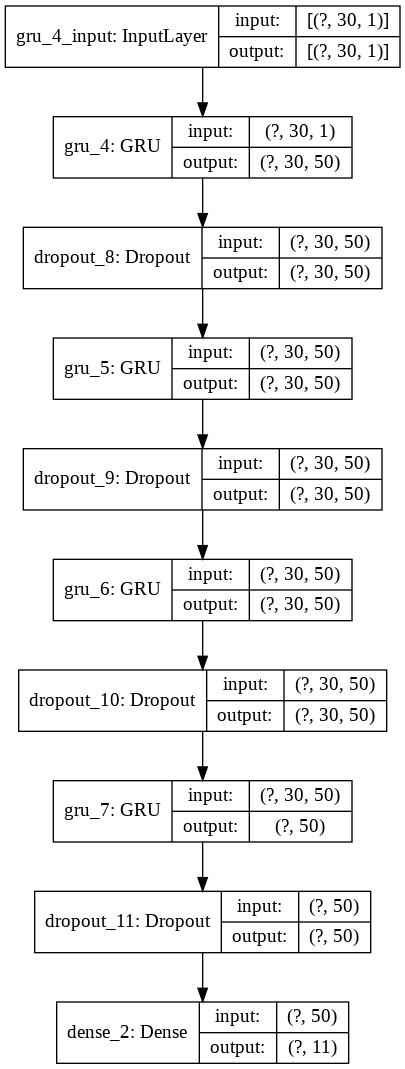

In [17]:
plot_model(model, to_file='topology.png',show_shapes=True)

In [ ]:
model.save(f"deep-lstm-{maxepoch}maxepoch-k{kfoldK}fold-{avgAccuray}avgacc.h5", save_format='.h5')
model.save(f"deep-lstm-{maxepoch}maxepoch-k{kfoldK}fold-{avgAccuray}avgacc")
